In [1]:
from thmodel import *
import pickle
with open('dict_data_final.pkl', 'rb') as f:
    dict_data_final = pickle.load(f)

# Ejemplo

In [2]:
x, y = dict_data_final['Beneixama']

In [4]:
grid = Grid(x=x, y=y)
grid.initialize(part=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01])
grid.compute_th_param()
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=10)

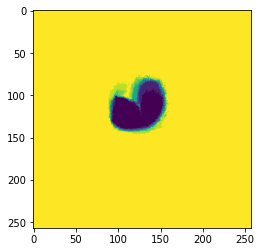

In [5]:
plt.imshow(grid.X0[:, :, -1].numpy())

# Resultados

In [6]:
## Parámetros ## 
P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01]
]
lista = list(dict_data_final.keys())
lista.append('Total')

In [7]:
from torchmetrics import Accuracy 
accuracy = Accuracy(task="multiclass", num_classes=3)
cross_entropy = torch.nn.CrossEntropyLoss()

In [8]:
i = -1
for part in P:
    i += 1
    for alpha in [1, 2]:
        for beta in [1, 2]:        
            #### dataframe ####
            df = pd.DataFrame(
                np.zeros((12, 5)),
                index = lista,
                columns=['Accuracy', 'CrossEntropy', 'Fired', 'ModelFired', 'ExpectedFired'],
                dtype=float
            )
            ####################
            print(f'P{i}_a{alpha}b{beta}')

            for key in dict_data_final.keys():
                
                x, y = dict_data_final[key]

                grid = Grid(x=x, y=y)
                grid.initialize(part=part)
                grid.compute_th_param(alpha=float(alpha), beta=float(beta))
                grid.submatrix()
                grid.enlargement_process()
                grid.montecarlo(n_it=100)

                ###### values ######
                y_torch_ce = torch.from_numpy(y[:, :, -1].flatten()).long()
                y_torch_acc = torch.from_numpy(y[:, :, -1])
                model_probs = torch.stack(
                [grid.X0[:, :, -1].flatten(), grid.X2[:, :, -1].flatten(), grid.X2[:, :, -1].flatten()], 
                dim=-1
                ).float()
                model_class = grid.X[:, :, -1]

                ###### metrics ######
                acc = accuracy(model_class, y_torch_acc).item()
                ce = cross_entropy(model_probs, y_torch_ce).item()
                fired = (y[:, :, -1] != 0).sum()
                model_fired = (grid.X[:, :, -1] != 0).sum().item()
                expected_fired = (1 - grid.X0[:, :, -1]).sum().item()

                metrics = [acc, ce, fired, model_fired, expected_fired]
                print('Name:    ', key, '  Metrica:   ', metrics)
                ######################

                df.loc[key] = metrics
            
            df.loc['Total'] = [
                df.Accuracy[:-1].mean(),
                df.CrossEntropy[:-1].mean(),
                df.Fired[:-1].mean(),
                df.ModelFired[:-1].mean(),
                df.ExpectedFired[:-1].mean()
            ]
            df.to_csv(f'data_th_P{i}_a{alpha}b{beta}.csv')

P0_a1b1
Name:     Artana   Metrica:    [0.9480991363525391, 0.6120128035545349, 2465, 1363, 1814.2799072265625]
Name:     Beneixama   Metrica:    [0.9847385883331299, 0.5698277950286865, 1476, 1046, 1092.4600830078125]
Name:     Beniarda   Metrica:    [0.5251706838607788, 1.0176622867584229, 31388, 615, 698.9099731445312]
Name:     Bolulla   Metrica:    [0.84210205078125, 0.7095428705215454, 10400, 53, 53.26000213623047]
Name:     Carcaixent   Metrica:    [0.96372389793396, 0.5912727117538452, 1032, 1370, 1369.550048828125]
Name:     Chella   Metrica:    [0.9151085019111633, 0.6563969254493713, 315, 5360, 5346.3701171875]
Name:     Gatova   Metrica:    [0.9340186715126038, 0.6275495290756226, 1447, 2915, 2978.080078125]
Name:     Llutxent   Metrica:    [0.9530197381973267, 0.6017954349517822, 2290, 1130, 1342.2900390625]
Name:     Montan   Metrica:    [0.9052672982215881, 0.6597656011581421, 5225, 1530, 2225.130126953125]
Name:     ValldEbo   Metrica:    [0.7912912964820862, 0.75734233